# PyTorch 1-Layer Neural Network (Linear Regression)

This notebook implements a 1-layer neural network (linear regression) using PyTorch with built-in functions like DataLoaders and optimizers. The model is trained using backpropagation on a synthetic dataset created from scratch.

## Features:
- Custom PyTorch Dataset and DataLoader
- 1-layer neural network without non-linearity
- Training with backpropagation using PyTorch optim
- Model parameter printing and evaluation
- Comprehensive visualization


In [1]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import random

# Set random seeds for reproducibility
torch.manual_seed(100)
np.random.seed(100)
random.seed(100)

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"NumPy version: {np.__version__}")


Libraries imported successfully!
PyTorch version: 2.2.2
NumPy version: 1.26.4


## 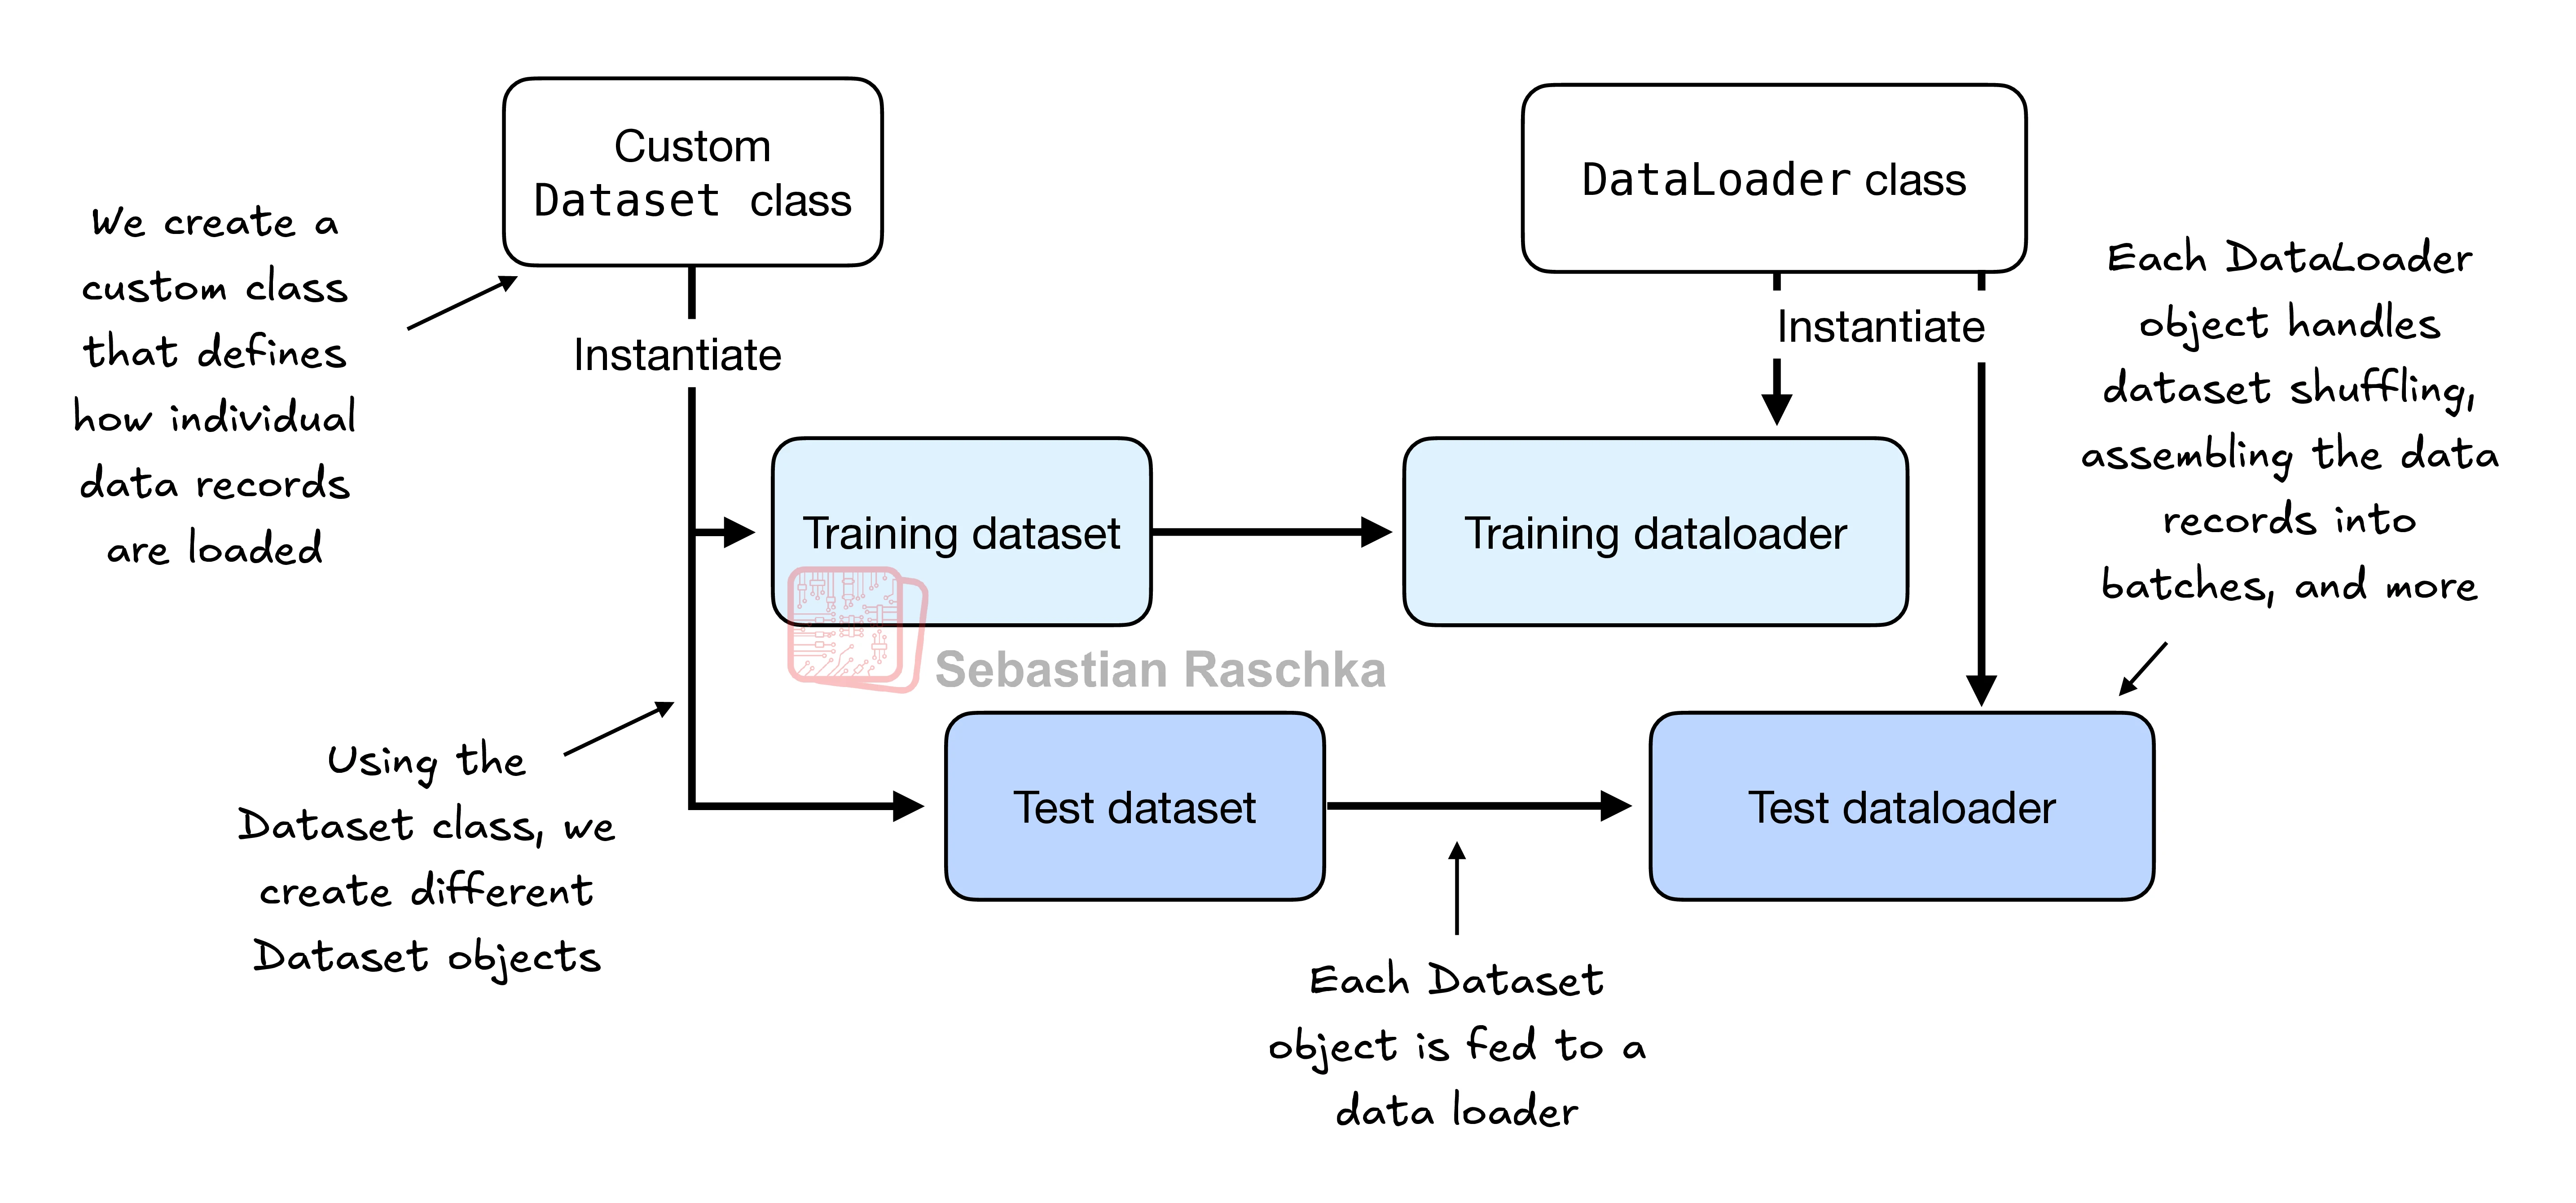. Custom PyTorch Dataset Class

This class implements a custom PyTorch Dataset for our synthetic data.


In [2]:
class SyntheticDataset(Dataset):
    """Custom PyTorch Dataset for synthetic regression data"""
    def __init__(self, n_samples, n_features, true_weights, true_bias, noise_std):
        """

        """
        # Generate random input features
        X = np.random.randn(n_samples, n_features)

        # FOR QUESTON 4, AUGMENT DATA:
        # X = np.column_stack([X, np.ones(n_samples)]).astype(np.float32)

        # Generate target values
        y = np.dot(X, true_weights) + true_bias

        # Add noise
        noise = np.random.normal(0, noise_std, n_samples)
        y = y + noise

        # Convert to PyTorch tensors
        X = torch.FloatTensor(X)
        y = torch.FloatTensor(y).reshape(-1, 1)

        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

## 2. Create DataLoaders

In [3]:
def get_dataloaders(Dataset, batch_size=32, train_split=0.7, val_split=0.15):
    # Split dataset: 70% train, 15% validation, 15% test
    train_size = int(0.7 * len(Dataset))
    val_size = int(0.15 * len(Dataset))
    test_size = len(Dataset) - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(
        Dataset, [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(10)
    )

    # Create data loaders
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print(f"\nData split:")
    print(f"  Training samples: {len(train_dataset)}")
    print(f"  Validation samples: {len(val_dataset)}")
    print(f"  Test samples: {len(test_dataset)}")
    print(f"  Batch size: {batch_size}")

    return train_loader, val_loader, test_loader

## 3. 1-Layer Neural Network Model

This is a simple linear regression model implemented as a 1-layer neural network without any non-linearity.


In [4]:
class OneLayerNN(nn.Module):
    """1-layer neural network (linear regression) without non-linearity"""

    def __init__(self, input_size, output_size=1):
        super(OneLayerNN, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Test the model
input_size = 4
model = OneLayerNN(input_size=input_size, output_size=1)
print(f"Model created:")
print(f"  Input size: {input_size}")
print(f"  Output size: 1")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters())}")
print(f"\nModel architecture:")
print(model)

# Test forward pass
test_input = torch.randn(5, input_size)
test_output = model(test_input)
print(f"\nTest forward pass:")
print(f"Input shape: {test_input.shape}")
print(f"Output shape: {test_output.shape}")
print(f"Sample output: {test_output[:2]}")


Model created:
  Input size: 4
  Output size: 1
  Total parameters: 5

Model architecture:
OneLayerNN(
  (linear): Linear(in_features=4, out_features=1, bias=True)
)

Test forward pass:
Input shape: torch.Size([5, 4])
Output shape: torch.Size([5, 1])
Sample output: tensor([[-0.2586],
        [ 1.4706]], grad_fn=<SliceBackward0>)


## 4. Training Function

This function trains the 1-layer neural network using backpropagation with PyTorch's built-in optimizer.
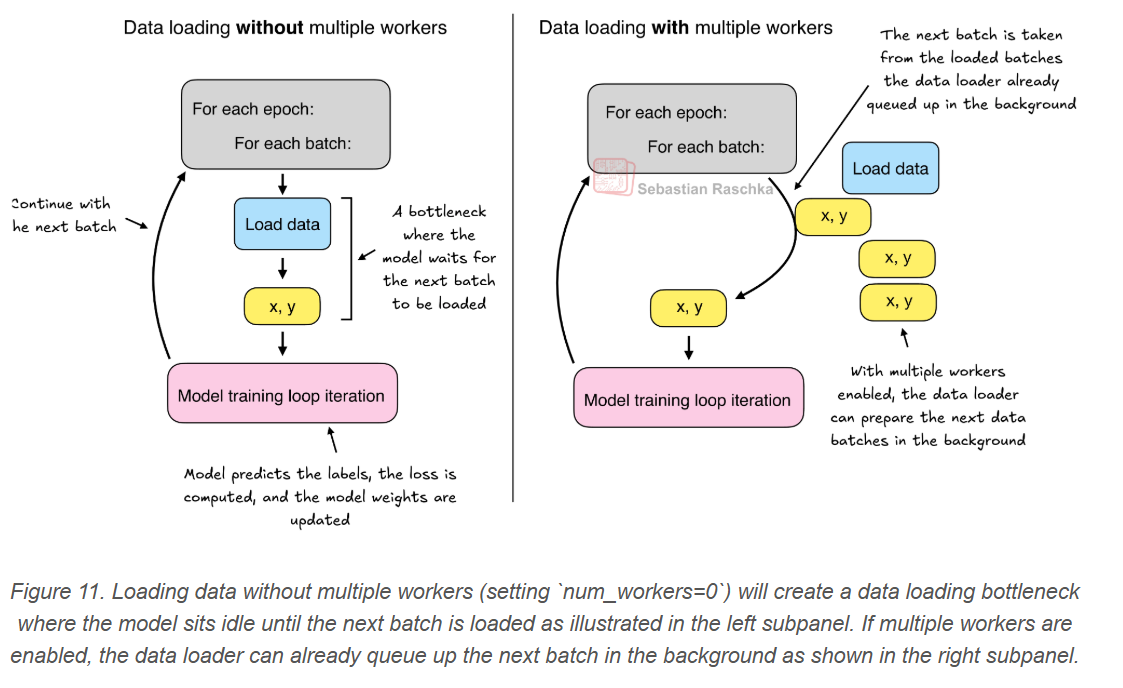

In [5]:
def train_model(model, train_loader, val_loader, num_epochs=100, learning_rate=0.01):
    """
    Train the 1-layer neural network using backpropagation

    Args:
        model: PyTorch model
        train_loader: Training data loader
        val_loader: Validation data loader
        num_epochs: Number of training epochs
        learning_rate: Learning rate for optimizer

    Returns:
        tuple: (train_losses, val_losses)
    """
    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate) #, weight_decay=0.01) # Added L2 Regularizer

    # Training history
    train_losses = []
    val_losses = []

    print("Training the 1-layer neural network...")
    print("-" * 50)

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_batches = 0

        batch_X, batch_y = next(iter(train_loader))
        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_X)
    
        # ===============================
        # CODE FOR PROBLEM 2
        # ===============================
        # New MSE loss operation
        loss = criterion(outputs, batch_y)
        # loss = torch.mean((outputs - batch_y)**2)

        # Backward pass (backpropagation)
        loss.backward()
        # Update weights
        optimizer.step()
        # # Compute gradient to update each weight manualy
        # # Have to make sure torch is not tracking comp graphs when updating
        # with torch.no_grad():
        #     # Gradient of loss w.r.t. the weight vector (MULT BY LEARNING RATE)
        #     model.linear.weight.data -= learning_rate * ((2/len(batch_X)) * batch_X.T @ (batch_X@model.linear.weight.T + model.linear.bias - batch_y)).T
        #     # Gradient of loss w.r.t. the bais vector (MULT BY LEARNING RATE)
        #     model.linear.bias.data -= learning_rate * (2/len(batch_X)) * torch.sum(batch_X@model.linear.weight.T + model.linear.bias - batch_y)


        train_loss += loss.item()
        train_batches += 1

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_batches = 0

        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
                val_batches += 1

        # Calculate average losses
        avg_train_loss = train_loss / train_batches
        avg_val_loss = val_loss / val_batches

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        # Print progress every 20 epochs
        if (epoch + 1) % 20 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], "
                  f"Train Loss: {avg_train_loss:.4f}, "
                  f"Val Loss: {avg_val_loss:.4f}")

    return train_losses, val_losses

print("Training function defined successfully!")


Training function defined successfully!


## 5. Testing Function

This function evaluates the model fit and prints all model parameters.


In [6]:
def test_model_fit(model, test_loader, print_params=True):
    """
    Test the model fit and print model parameters

    Args:
        model: Trained PyTorch model
        test_loader: Test data loader
        print_params (bool): Whether to print model parameters

    Returns:
        dict: Evaluation metrics
    """
    model.eval()

    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            predictions = model(batch_X)
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(batch_y.cpu().numpy())

    # Convert to numpy arrays
    predictions = np.array(all_predictions).flatten()
    targets = np.array(all_targets).flatten()

    # Calculate metrics
    mse = mean_squared_error(targets, predictions)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(targets - predictions))
    r2 = r2_score(targets, predictions)

    # Print model parameters
    if print_params:
        print("\n" + "="*60)
        print("MODEL PARAMETERS")
        print("="*60)

        # Get model weights and bias
        weights = model.linear.weight.data.numpy().flatten()
        bias = model.linear.bias.data.item()

        print(f"Weights (coefficients):")
        for i, w in enumerate(weights):
            print(f"  w{i+1} = {w:.6f}")

        print(f"Bias (intercept): {bias:.6f}")

        print(f"\nModel Architecture:")
        print(f"  Input size: {model.linear.in_features}")
        print(f"  Output size: {model.linear.out_features}")
        print(f"  Total parameters: {sum(p.numel() for p in model.parameters())}")

    # Print evaluation metrics
    print(f"\n" + "="*60)
    print("EVALUATION METRICS")
    print("="*60)
    print(f"Mean Squared Error (MSE): {mse:.6f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
    print(f"Mean Absolute Error (MAE): {mae:.6f}")
    print(f"R-squared (R²): {r2:.6f}")

    return {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'predictions': predictions,
        'targets': targets
    }

print("Testing function defined successfully!")


Testing function defined successfully!


## 6. Plotting Function

This function creates comprehensive visualizations of the training process and model performance.


In [7]:
def plot_results(train_losses, val_losses, test_results, model):
    """Plot training curves and model performance"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot training curves
    axes[0, 0].plot(train_losses, label='Training Loss', color='blue', linewidth=2)
    axes[0, 0].plot(val_losses, label='Validation Loss', color='red', linewidth=2)
    axes[0, 0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss (MSE)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Plot actual vs predicted
    targets = test_results['targets']
    predictions = test_results['predictions']

    axes[0, 1].scatter(targets, predictions, alpha=0.6, color='blue', s=30)
    min_val = min(targets.min(), predictions.min())
    max_val = max(targets.max(), predictions.max())
    axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    axes[0, 1].set_xlabel('Actual Values')
    axes[0, 1].set_ylabel('Predicted Values')
    axes[0, 1].set_title('Actual vs Predicted Values', fontsize=14, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Plot residuals
    residuals = targets - predictions
    axes[1, 0].scatter(predictions, residuals, alpha=0.6, color='green', s=30)
    axes[1, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
    axes[1, 0].set_xlabel('Predicted Values')
    axes[1, 0].set_ylabel('Residuals')
    axes[1, 0].set_title('Residual Plot', fontsize=14, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)

    # Plot feature importance (model weights)
    feature_names = [f'Feature {i+1}' for i in range(len(model.linear.weight.data.numpy().flatten()))]
    weights = model.linear.weight.data.numpy().flatten()
    colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold', 'plum']

    bars = axes[1, 1].bar(feature_names, weights, color=colors[:len(weights)])
    axes[1, 1].set_title('Feature Weights (Model Coefficients)', fontsize=14, fontweight='bold')
    axes[1, 1].set_ylabel('Weight Value')
    axes[1, 1].grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for bar, weight in zip(bars, weights):
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                        f'{weight:.3f}', ha='center', va='bottom' if height > 0 else 'top')

    plt.tight_layout()
    plt.show()

print("Plotting function defined successfully!")


Plotting function defined successfully!


## 7. Complete Pipeline Execution

This cell runs the complete machine learning pipeline from data creation to model evaluation.


In [34]:
# Set random seed for some consistancy
import random
random.seed(42)

# Create synthetic dataset
print("Creating synthetic dataset from scratch...")
n_samples = 1000 # 50
n_features = 4 # 100
# true_w = np.random.normal(size=n_features, scale=0.01) # make weights gaussian distributed 
# true_b = 0 # Bias is 0
true_w = np.array([2.5,1.8,2.9,-5.2]) # Added 2.71 here representing the bias in succint form
true_b = 2.71
noise_std = 0.1

MyDataset = SyntheticDataset(n_samples, n_features, true_w, true_b, noise_std)
X_orig = MyDataset.X
X = X_orig
y = MyDataset.y
print(f"Dataset created: {X.shape[0]} samples, {X.shape[1]} features")

Creating synthetic dataset from scratch...
Dataset created: 1000 samples, 4 features


In [35]:
# Make the data loaders
# Augment dataset to have column of 1's
MyDataset.X = np.column_stack([X_orig, np.ones(n_samples)]).astype(np.float32)
X = MyDataset.X
train_loader, val_loader, test_loader = get_dataloaders(MyDataset, batch_size=32, train_split=0.7, val_split=0.15)


Data split:
  Training samples: 700
  Validation samples: 150
  Test samples: 150
  Batch size: 32


In [40]:
# Create and train model
print("\nCreating and training the model...")
input_size = X.shape[1]
model = OneLayerNN(input_size=input_size, output_size=1)

print(f"Model created:")
print(f"  Input size: {input_size}")
print(f"  Output size: 1")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters())}")

# Train the model
train_losses, val_losses = train_model(
    model, train_loader, val_loader,
    num_epochs=1000, learning_rate=0.01
)



Creating and training the model...
Model created:
  Input size: 5
  Output size: 1
  Total parameters: 6
Training the 1-layer neural network...
--------------------------------------------------
Epoch [20/1000], Train Loss: 20.1796, Val Loss: 17.6549
Epoch [40/1000], Train Loss: 7.0730, Val Loss: 7.6613
Epoch [60/1000], Train Loss: 4.9395, Val Loss: 3.1426
Epoch [80/1000], Train Loss: 1.0579, Val Loss: 1.4428
Epoch [100/1000], Train Loss: 0.6161, Val Loss: 0.6871
Epoch [120/1000], Train Loss: 0.4940, Val Loss: 0.3106
Epoch [140/1000], Train Loss: 0.1594, Val Loss: 0.1456
Epoch [160/1000], Train Loss: 0.1107, Val Loss: 0.0700
Epoch [180/1000], Train Loss: 0.0432, Val Loss: 0.0361
Epoch [200/1000], Train Loss: 0.0223, Val Loss: 0.0205
Epoch [220/1000], Train Loss: 0.0160, Val Loss: 0.0143
Epoch [240/1000], Train Loss: 0.0149, Val Loss: 0.0115
Epoch [260/1000], Train Loss: 0.0117, Val Loss: 0.0104
Epoch [280/1000], Train Loss: 0.0115, Val Loss: 0.0098
Epoch [300/1000], Train Loss: 0.0152

In [41]:
# Test the model and print parameters
print("\nTesting model fit...")
test_results = test_model_fit(model, test_loader, print_params=True)



Testing model fit...

MODEL PARAMETERS
Weights (coefficients):
  w1 = 2.499527
  w2 = 1.799428
  w3 = 2.898076
  w4 = -5.208712
  w5 = 1.494308
Bias (intercept): 1.219093

Model Architecture:
  Input size: 5
  Output size: 1
  Total parameters: 6

EVALUATION METRICS
Mean Squared Error (MSE): 0.009373
Root Mean Squared Error (RMSE): 0.096813
Mean Absolute Error (MAE): 0.076937
R-squared (R²): 0.999810



Generating plots...


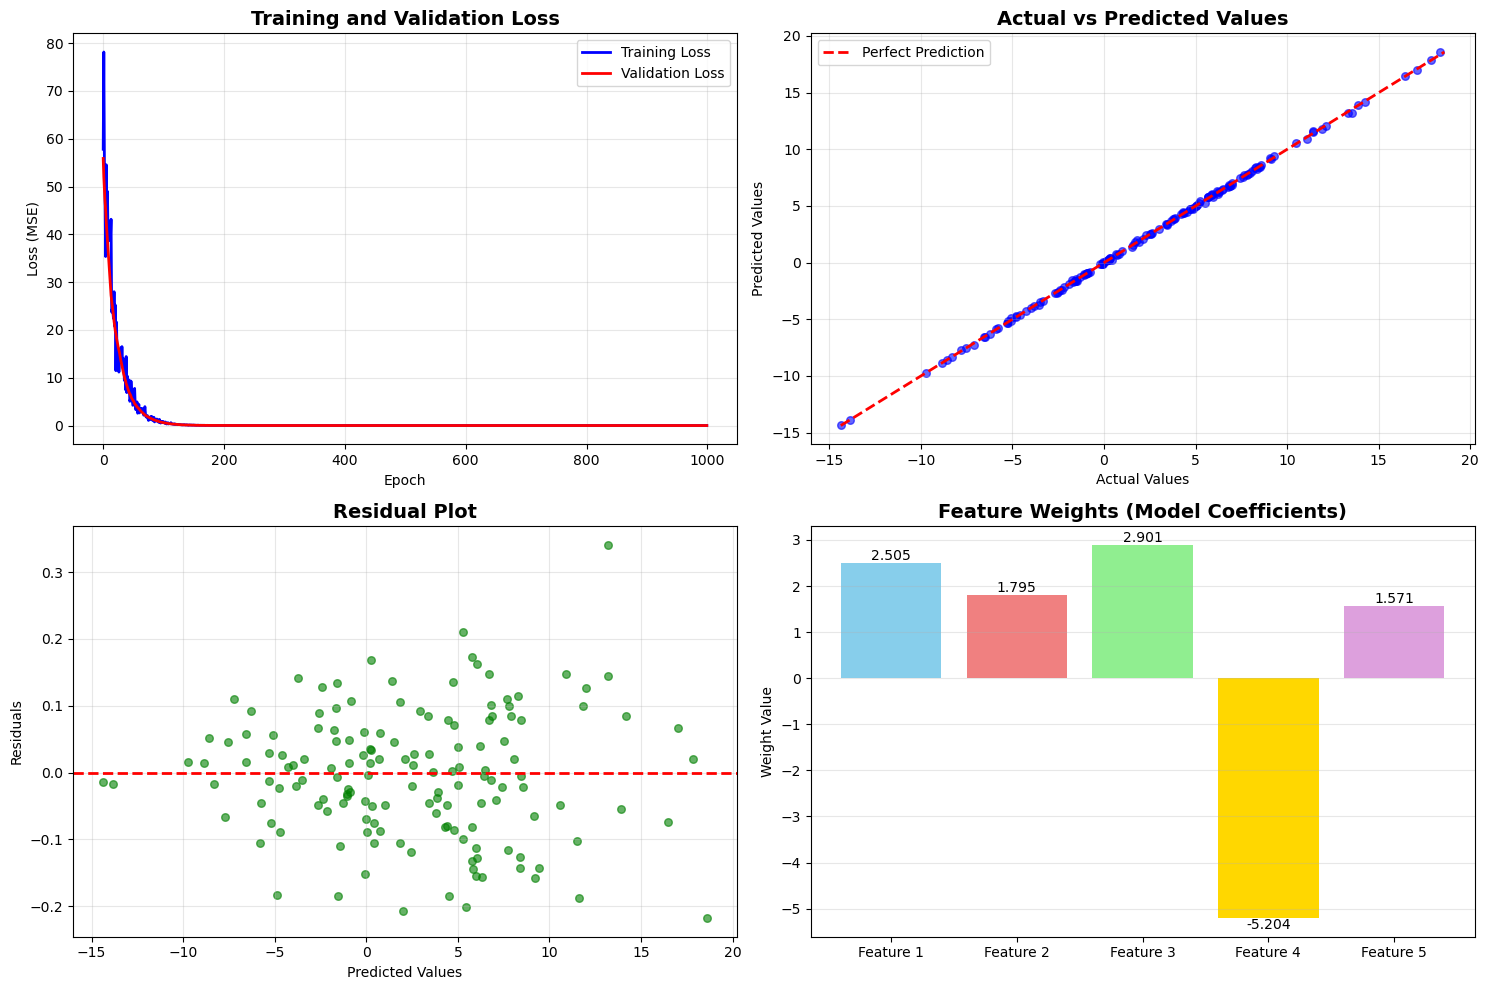


Training completed successfully!
Final R² score: 0.9998


In [12]:
# Generate plots
print("\nGenerating plots...")
plot_results(train_losses, val_losses, test_results, model)

print(f"\nTraining completed successfully!")
print(f"Final R² score: {test_results['r2']:.4f}")




1.   Run this notebook and inspect the output. Make sure you understand how each line of the code. Feel free to use AI tools to help you understand the code.
- I have ran the notebook and understand the code.
---

2.   Replace the following lines from the training function by your own code, i.e., write your own Python code for computing the loss, gradient, and the update step. You can use AI tools to understand how to access the neural network parameters from nn.module, but I would suggest not using them to write these functions. These are simple one-liners which you should try by yourself.

loss = criterion(outputs, batch_y)<br>
loss.backward()<br>
optimizer.step()

**I have inseted my new python code in the function, I will put it here as well for easy reference**

```python
# ===============================
# CODE FOR PROBLEM 2
# ===============================
# New MSE loss operation
# loss = criterion(outputs, batch_y)
loss = torch.mean((outputs - batch_y)**2)

# Backward pass (backpropagation)
# loss.backward()
# Update weights
# optimizer.step()
# Compute gradient to update each weight manualy
# Have to make sure torch is not tracking comp graphs when updating
with torch.no_grad():
    # Gradient of loss w.r.t. the weight vector (MULT BY LEARNING RATE)
    model.linear.weight.data -= learning_rate * ((2/len(batch_X)) * batch_X.T @ (batch_X@model.linear.weight.T + model.linear.bias - batch_y)).T
    # Gradient of loss w.r.t. the bais vector (MULT BY LEARNING RATE)
    model.linear.bias.data -= learning_rate * (2/len(batch_X)) * torch.sum(batch_X@model.linear.weight.T + model.linear.bias - batch_y)
```

---

3. Weight decay: Change the code to construct a dataset with 100 features and only 50 samples. Choose the true weights to be Gaussian distributed with variance 0.01 and the bias to be 0. What will happen to the training error and the testing error if you try to train the model without any changes? Now, add a $L_2$ regularizer and see how that affects the performance. What is the takeaway from this?

- When I change the dataset in this way and choose gausian true weights and a bias of 0, I find that the training loss converges to 0, but the validation and testing loss remain very high.  
- When I add in a L2 regularizor (in the optimizer), I find that the training loss remains higher and converges to 0 at a slower rate, and the validation and testing loss are lower in general. 
- This tells us that adding in L2 regularization will help decrease variance in the model, and will help the model generalize better rather than overfitting the data (which is easy when there is a greater number of features than datapoints).
- I left all of my changes in comments within the code so you could see the changes I made when I change the code back to the original parameters in question 4

---

4. Succint form: Keep the parameters from the original notebook and create a dataset. Augment the dataset with a column of ones and train a model with the augmented dataset. Explain if your answer makes sense.

- From the results, I notice that the coefficient for the new $w_5$ weight that corresponds to this new 1's column can be added to the bias weight to get roughly the true bias (2.71)
- This makes sense, because the added column of 1's serves as an intercept of its own. If the bias term were to be removed, the coefficient for $w_5$ would be equal to about 2.71 (true bias). Because the bias term is still included, they sum to about 2.71.

---

5. (Optional) Bias-Variance Tradeoff - Consider a linear model with $y = 1+x + \epsilon$, where $\epsilon \sim \mathcal{N}(0,1)$. We are going to generate 30 different datasets $\mathbf{X}_1,\ldots,\mathbf{X}_{30}$ each with $n = 3$ data points. For all these datasets choose the 3 values of $x$ to be 0,1,2. Notice that $\epsilon$ is still different for all these points. For each of these datasets fit three models as follows
\begin{align}
M_0: \hat{y} & = & w_0 \\
M_1: \hat{y} & = & w_0 + w_1 x \\
M_2: \hat{y} & = & w_0 + w_1 x + w_2 x^2
\end{align}
For each dataset, you would have fit a model. Using that model, predict the value of $y$ at $x=5$. You will get 30 different prediction for each of the three models. Which of these three models has the highest bias and which has the highest variance?

- Model $M_0$ has the highest bias, as it does not fit to the data at all, only to the constant term. Because of this, it will output the same value for each dataset that it sees, making it bias twoards that value.
- Model $M_2$ has the highest variance. It takes into account more feature relationships, which could cause it to overfit to training data and give inconsistant results for different datasets that it sees.